In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/EffecienDet-D0

/content/drive/MyDrive/EffecienDet-D0


In [3]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [4]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/MyDrive/EffecienDet-D0/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1657644 sha256=3ce4684051b681d0e7ecdba3a33e4fed5f459aa354eca6430fdf8d33a290d340
  Stored in directory: /tmp/pip-ephem-wheel-cache-udaohv71/wheels/f9/f5/c5/c406acad060dd860405f1d9a175f046edeee5f6cb9bcdc80b2
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=36c719230ebd0cccb6bd2146358f52da0e677dcf3d3e9fd987392d99dbf36d69
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=d81ddc81b93317949655765dbf05f15b2bce9663a3ef1b598a6c24766e0327e8
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=28d444e567d8defe3b119af838

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [6]:
#run model builder test
!python /content/drive/MyDrive/EffecienDet-D0/models/research/object_detection/builders/model_builder_tf2_test.py

2021-08-17 04:55:19.417360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.11: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-08-17 04:55:21.383150: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 04:55:21.435320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 04:55:21.435923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-17 04:55:21.435968: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfull

In [7]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [8]:
#%mkdir /content/drive/MyDrive/EffecienDet-D0/training
%cd /content/drive/MyDrive/EffecienDet-D0/training

/content/drive/MyDrive/EffecienDet-D0/training


In [9]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/drive/MyDrive/EffecienDet-D0/training/test.record'
train_record_fname = '/content/drive/MyDrive/EffecienDet-D0/training/train.record'
label_map_pbtxt_fname = '/content/drive/MyDrive/EffecienDet-D0/training/label_map.pbtxt'

In [10]:
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'

num_steps = 40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [11]:
#download pretrained weights
#%mkdir /content/models/research/deploy/
%cd /content/drive/MyDrive/EffecienDet-D0/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/drive/MyDrive/EffecienDet-D0/models/research/deploy
--2021-08-17 04:56:13--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.137.128, 2607:f8b0:4023:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.137.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz.2’

efficientdet_d0_coc 100%[===================>]  29.31M  55.8MB/s    in 0.5s    

2021-08-17 04:56:14 (55.8 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz.2’ saved [30736482/30736482]



In [12]:
%cd /content/drive/MyDrive/EffecienDet-D0/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/drive/MyDrive/EffecienDet-D0/models/research/deploy
--2021-08-17 04:56:21--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config.2’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0.001s  

2021-08-17 04:56:21 (5.31 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config.2’ saved [4630/4630]



In [13]:
#prepare
pipeline_fname = '/content/drive/MyDrive/EffecienDet-D0//models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/drive/MyDrive/EffecienDet-D0/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)

In [14]:
import re

%cd /content/drive/MyDrive/EffecienDet-D0/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "/content/drive/MyDrive/EffecienDet-D0/models/research/deploy/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "/content/drive/MyDrive/EffecienDet-D0/training/train.record"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "/content/drive/MyDrive/EffecienDet-D0/training/test.record"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "/content/drive/MyDrive/EffecienDet-D0/training/label_map.pbtxt"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: 16'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: 2000'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: 36'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "detection"'.format('detection'), s)
        
    f.write(s)

/content/drive/MyDrive/EffecienDet-D0/models/research/deploy
writing custom configuration file


In [15]:
%cat /content/drive/MyDrive/EffecienDet-D0/models/research/deploy/pipeline_file.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 36
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      

In [16]:
pipeline_file = '/content/drive/MyDrive/EffecienDet-D0/models/research/deploy/pipeline_file.config'
model_dir = '/content/drive/MyDrive/EffecienDet-D0/training/'

In [ ]:
!python /content/drive/MyDrive/EffecienDet-D0/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-07-02 17:58:23.808608: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-02 17:58:25.616071: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-02 17:58:25.645201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-02 17:58:25.645806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-07-02 17:58:25.645850: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-02 17:58:25.655616: I tensorflow/stream_executor/platform/default

In [17]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/EffecienDet-D0/training/train'

<IPython.core.display.Javascript object>

In [19]:
%ls '/content/drive/MyDrive/EffecienDet-D0/training/'

checkpoint                  ckpt-3.index                test.record
ckpt-2.data-00000-of-00001  ckpt-4.data-00000-of-00001  train/
ckpt-2.index                ckpt-4.index                train.record
ckpt-3.data-00000-of-00001  label_map.pbtxt


In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/content/drive/MyDrive/EffecienDet-D0/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/drive/MyDrive/EffecienDet-D0/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-07-06 08:12:48.408384: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-06 08:12:50.595137: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-06 08:12:50.654697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-06 08:12:50.655450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-07-06 08:12:50.655529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-06 08:12:50.798018: I tensorflow/stream_exe

In [20]:
%ls '/content/drive/MyDrive/EffecienDet-D0/fine_tuned_model/saved_model/'

assets/  saved_model.pb  variables/


In [ ]:
# Mount your drive to colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#%mkdir /content/drive/MyDrive/EffecienDet-D0/test/
#%cd /content/drive/MyDrive/EffecienDet-D0/test/

/content/test


In [ ]:
%cd /content/drive/MyDrive/EffecienDet-D0/test/
!jar xvf dataset_plate_detection.zip

/content/test
  created: dataset_plate_detection/
  created: dataset_plate_detection/test/
 inflated: dataset_plate_detection/test/108.E 5860 ST-03-21.jpeg
 inflated: dataset_plate_detection/test/109.E 4026 SL-02-20.jpg
 inflated: dataset_plate_detection/test/126.E 3453 TN-06-22.jpeg
 inflated: dataset_plate_detection/test/127.E 6932 TW-05-18.jpg
 inflated: dataset_plate_detection/test/134.E 2194 Q-07-18.jpeg
 inflated: dataset_plate_detection/test/144.E 3063 RS-07-22.jpeg
 inflated: dataset_plate_detection/test/150.E 6686 PAI-01-22.jpg
 inflated: dataset_plate_detection/test/155.E 3392 TZ-07-18.jpeg
 inflated: dataset_plate_detection/test/164.E 3543 PAG-09-21.jpg
 inflated: dataset_plate_detection/test/170.E 3913 QS-04-20.jpeg
 inflated: dataset_plate_detection/test/20171212_073415.jpg
 inflated: dataset_plate_detection/test/20171212_073435.jpg
 inflated: dataset_plate_detection/test/20171212_100708.jpg
 inflated: dataset_plate_detection/test/20171212_124349.jpg
 inflated: dataset_pla

In [21]:
%cd /content/drive/MyDrive/EffecienDet-D0

/content/drive/MyDrive/EffecienDet-D0


In [22]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline


In [23]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [26]:
%ls '/content/drive/MyDrive/EffecienDet-D0/training/'

checkpoint                  ckpt-3.index                test.record
ckpt-2.data-00000-of-00001  ckpt-4.data-00000-of-00001  train/
ckpt-2.index                ckpt-4.index                train.record
ckpt-3.data-00000-of-00001  label_map.pbtxt


In [27]:
import pathlib

filenames = list(pathlib.Path('/content/drive/MyDrive/EffecienDet-D0/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/drive/MyDrive/EffecienDet-D0/training/ckpt-2.index'), PosixPath('/content/drive/MyDrive/EffecienDet-D0/training/ckpt-3.index'), PosixPath('/content/drive/MyDrive/EffecienDet-D0/training/ckpt-4.index')]


In [28]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

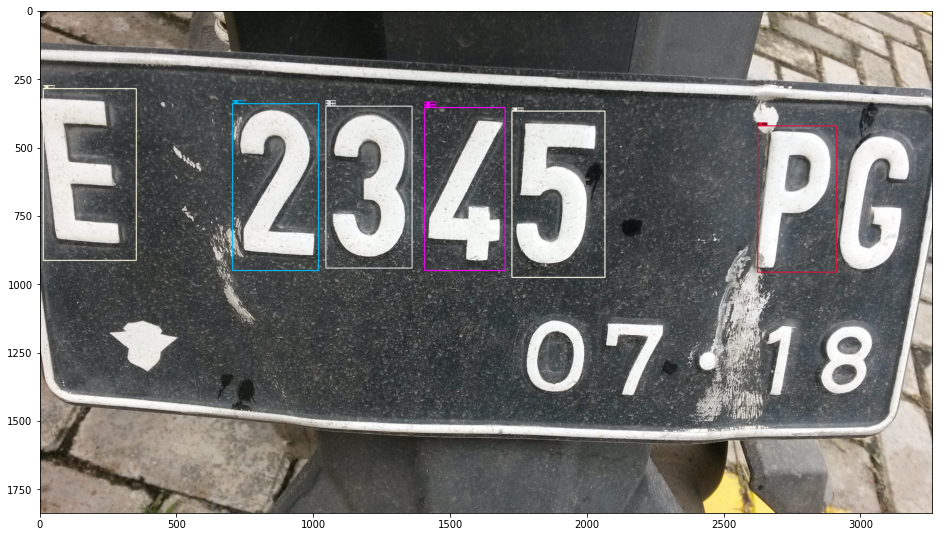

In [35]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/drive/MyDrive/EffecienDet-D0/test/dataset_plate_detection/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
#image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=7,
      min_score_thresh=.6,
      agnostic_mode=False,
      )

plt.figure(figsize=(16,20))
plt.imshow(image_np_with_detections)
plt.savefig('image.png', dpi=300, bbox_inches='tight')
plt.show()

I want to convert the detected image label to text, how do I do that?